# M3_Week 1_Assignment
- Marc Pérez Quintana  <br>
- Basem Elbarashy <br>
- Sergi Garcia Bordils <br>


In [114]:
import cv2
import numpy as np
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

## Read the train and test files

In [115]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

class_count_test = {}
for label in test_labels:
    if label in class_count_test:
        class_count_test[label] += 1
    else: 
        class_count_test[label] = 1
        
class_count_train = {}
for label in train_labels:
    if label in class_count_train:
        class_count_train[label] += 1
    else: 
        class_count_train[label] = 1
        
print("TRAIN: ", class_count_train)
print("TEST: ", class_count_test)

TRAIN:  {'Opencountry': 292, 'tallbuilding': 248, 'street': 212, 'mountain': 260, 'inside_city': 214, 'coast': 244, 'forest': 227, 'highway': 184}
TEST:  {'Opencountry': 118, 'tallbuilding': 108, 'street': 80, 'mountain': 114, 'inside_city': 94, 'coast': 116, 'forest': 101, 'highway': 76}


## Create 5 Stratified Folds for Cross-validation

In [116]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
print(len(train_images_filenames))
print(len(train_labels))
skf_split = skf.split(train_images_filenames, train_labels)
for train_index, validation_index in skf_split:
    print("length of validation_index", len(test_index))
    print("VALIDATION:", validation_index)
    class_count = {}
    for index in validation_index:
        label = train_labels[index]
        if label in class_count:
            class_count[label] += 1
        else: 
            class_count[label] = 1
    print(class_count)
    print("-------------------------")


1881
1881
length of validation_index 372
VALIDATION: [   4   11   12   17   18   27   39   51   58   59   62   85   88   89
   90   91   99  102  105  110  117  119  120  123  127  132  139  146
  154  157  164  174  177  179  180  181  185  189  201  202  204  207
  208  214  218  224  229  232  238  243  258  266  267  274  279  280
  289  290  291  296  303  310  311  319  321  323  325  326  327  330
  331  336  343  350  354  359  361  365  377  381  382  383  385  398
  399  408  409  410  411  414  424  462  469  473  475  478  494  498
  502  510  511  512  516  518  530  532  533  535  536  540  547  554
  555  565  567  569  570  571  574  575  580  587  598  603  620  621
  625  627  629  631  635  641  642  643  644  658  663  668  684  688
  698  699  700  702  704  706  725  726  729  733  743  744  752  756
  767  774  777  779  782  792  794  798  803  805  810  811  816  817
  819  822  832  845  857  858  869  870  877  881  882  885  887  889
  899  908  916  921  92

## Set the parameters of the execution

In [117]:
num_features = 400 #number of features for the SIFT detector but for densesift it depends on step value
step = 20
k = 300 # codebook size / number of clusters for KMeans / number of words
num_neighbors = 10 #number of neighbors (k) for the k-nn classifier
knn_metric = 'manhattan'#distance for the k-nn classifier
denseSift = True #True if Dense SIFT is to be used, False for classical SIFT
pyramidDepth = 0 # 0-> No spatial pyramid, 1-> whole image + 4 subimages, 2-> lower levels + 16 subimages, ...

## Implementing Dense SIFT
- compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [118]:
def denseSIFT(images_filenames, labels):
    SIFTdetector = cv2.xfeatures2d.SIFT_create(num_features) # Create a SIFT object detector and descriptor
    descriptors = []
    label_per_descriptor = []
    kpts = []

    for filename, labels in zip(images_filenames, labels):
        filename = filename.replace("../../Databases/MIT_split", ".")
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)

        if denseSift:
            height, width = gray.shape
            kpt = [cv2.KeyPoint(x, y, step) for y in range(0, gray.shape[0], step) 
                                            for x in range(0, gray.shape[1], step)]
            _, des = SIFTdetector.compute(gray, kpt)

        else:
            kpt, des = SIFTdetector.detectAndCompute(gray, None)

        kpts.append(kpt)
        descriptors.append(des)
        label_per_descriptor.append(labels)

    return (kpts, descriptors, np.vstack(descriptors))

Train_kpts, Train_descriptors, D = denseSIFT(train_images_filenames, train_labels)

## Compute k-means clustering on the descriptor space

In [119]:
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=6000, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=300, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

### For each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [120]:
def get_visual_words(Train_descriptors):
    for level in range(pyramidDepth+1):
        if(level == 0):
            pyramid_visual_words = np.zeros((len(Train_descriptors), k), dtype=np.float32)
            for i in range(len(Train_descriptors)):
                for word in codebook.predict(Train_descriptors[i]):   
                    pyramid_visual_words[i,word]+=1
        else:
            for x in range(2**level):
                    for y in range(2**level): 
                        visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
                        for i in range(len(Train_descriptors)):    
                            words = codebook.predict(Train_descriptors[i])
                            for keypoint in range(len(Train_descriptors[i])):
                                x_pt, y_pt = Train_kpts[i][keypoint].pt
                                if (x_pt>=x*256/(2**level) and x_pt<(x+1)*256/(2**level) and y_pt>=x*256/(2**level) and y_pt<(x+1)*256/(2**level)):
                                    visual_words[i, words[keypoint]]+=1
                        pyramid_visual_words = np.append(pyramid_visual_words, visual_words, axis=1)
        #print(pyramid_visual_words.shape)
    return pyramid_visual_words
visual_words = get_visual_words(Train_descriptors)

## Build a k-nn classifier and train it with the train descriptors

In [121]:
knn = KNeighborsClassifier(n_neighbors=num_neighbors,n_jobs=-1,metric=knn_metric)
knn.fit(visual_words, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')

## Compute the test descriptors and compute the accuracy of the model

In [122]:
Test_kpts, Test_descriptors, D = denseSIFT(test_images_filenames, test_labels)
words = [codebook.predict(des) for des in Test_descriptors]
visual_words_test = get_visual_words(Test_descriptors)


In [123]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

77.32342007434944


We save a log file of the execution

In [124]:
with open('parameters_execution.log', 'a') as f:
    f.write('denseSift: '+str(denseSift)+', '+
            'num_features: '+str(num_features)+', '+
            'k: '+str(k)+', '+
            'num_neighbors: '+str(num_neighbors)+', '+
            'knn_metric: '+str(knn_metric)+', '+
            'step: '+str(step)+', '+
            'pyramidDepth: '+str(pyramidDepth)+', '+
            'accuracy: '+str(accuracy)+'\n')
    

## We tuned parameters individually first and then tuned all at the same time
### Visualizing how each parameter affect the accuracy after trying several values for each one

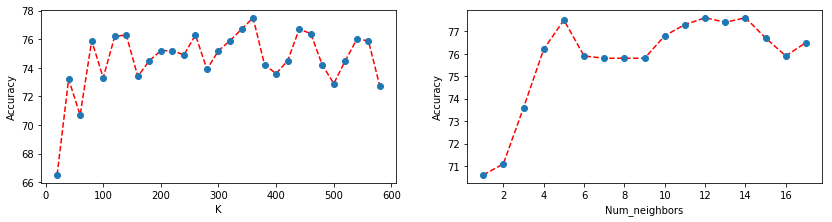

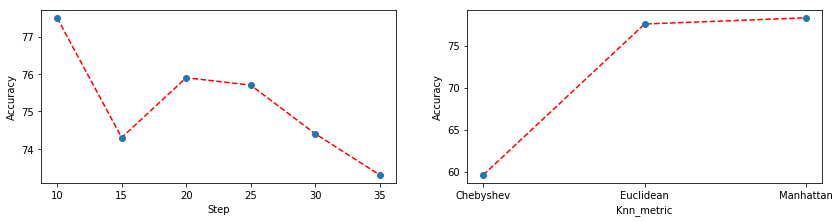

In [125]:
import numpy as np
import matplotlib.pyplot as plt


k_range             = np.arange(20, 600, 20)
num_neighbors_range = np.arange(1, 18, 1)
step_range          = np.arange(10,40,5)
knn_metric_range    = ['Chebyshev','Euclidean','Manhattan']

k_acc               = [66.5,73.2,70.7,75.9,73.3,76.2,76.3,73.4,74.5,75.2,75.2,74.9,76.3,73.9,75.2,75.9,76.7,77.5,74.2,73.6,74.5,76.7,76.4,74.2,72.9,74.5,76.0, 75.9, 72.7]
num_neighbors_acc   = [70.6,71.1,73.6,76.2,77.5,75.9,75.8,75.8,75.8,76.8,77.3,77.6,77.4,77.6,76.7,75.9, 76.5]
step_acc            = [77.5, 74.3, 75.9, 75.7, 74.4, 73.3]
knn_metric_acc      = [59.60,77.57, 78.31]

plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.plot(k_range, k_acc, 'r--');  plt.plot(k_range, k_acc, 'o');  
plt.xlabel('K');  plt.ylabel('Accuracy');

plt.subplot(222)
plt.plot(num_neighbors_range, num_neighbors_acc, 'r--');  plt.plot(num_neighbors_range, num_neighbors_acc, 'o');  
plt.xlabel('Num_neighbors');  plt.ylabel('Accuracy');


plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.plot(step_range, step_acc, 'r--');  plt.plot(step_range, step_acc, 'o');  
plt.xlabel('Step');  plt.ylabel('Accuracy');


plt.subplot(222)
plt.plot(knn_metric_range, knn_metric_acc, 'r--');  plt.plot(knn_metric_range, knn_metric_acc, 'o');  
plt.xlabel('Knn_metric');  plt.ylabel('Accuracy');

### Tuning all parameters at the same time, visualizing the accuracy versus different configurations of parameters 


    
| denseSift | num_features   | k | num_neighbors | knn_metric | step | accuracy |
|------|------|------|------|------|------|------|
|   True  | 676 | 100  | 5 | manhattan  | 10 | 77.3  | 
|   True  | 676 | 100  | 5 | euclidean  | 10 | 73.3  | 
|   True  | 169 | 100  | 5 | manhattan  | 20 | 74.3  | 
|   True  | 169 | 100  | 5 | euclidean  | 20 | 74.3  | 
|   True  | 676 | 100  | 10 | manhattan  | 10 | 77.6  | 
|   True  | 676 | 100  | 10 | euclidean  | 10 | 74.9  | 
|   True  | 169 | 100  | 10 | manhattan  | 20 | 75.4  | 
|   True  | 169 | 100  | 10 | euclidean  | 20 | 74.5  | 
|   True  | 676 | 300  | 5 | manhattan  | 10 | 80.9  | 
|   True  | 676 | 300  | 5 | euclidean  | 10 | 75.2  | 
|   True  | 169 | 300  | 5 | manhattan  | 20 | 77.1  | 
|   True  | 169 | 300  | 5 | euclidean  | 20 | 75.9  | 
|   True  | 676 | 300  | 10 | manhattan  | 10 | 80.5  | 
|   True  | 676 | 300  | 10 | euclidean  | 10 | 75.3  | 
|   True  | 169 | 300  | 10 | manhattan  | 20 | 77.1  | 
|   True  | 169 | 300  | 10 | euclidean  | 20 | 76.4  | 
|   True  | 2704 | 300  | 10 | manhattan  | 5 | 80.7  | 
|   False  | 500 | 300  | 5 | manhattan  | - | 48.3  | 
|   False  | 800 | 300  | 5 | manhattan  | - | 52  | 

